In [218]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm, halfnorm, kstest, ks_2samp, wilcoxon, mannwhitneyu, probplot
from scipy.optimize import curve_fit
import pickle
from statsmodels.graphics.gofplots import qqplot_2samples

In [50]:
mars = np.genfromtxt('harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('harp_uranus.dat', usecols=np.arange(0, 8))

In [103]:
mars_unc = np.genfromtxt('harp_mars_unc.dat')
jupiter_unc = np.genfromtxt('harp_jupiter_unc.dat')
uranus_unc = np.genfromtxt('harp_uranus_unc.dat')
planets_unc = np.concatenate((mars_unc[:,9], jupiter_unc[:,8], uranus_unc[:,8]), axis=0)

In [109]:
yerr = np.mean(planets_unc[planets_unc!=0])
print(yerr)

0.102780674017


In [51]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]

In [52]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])

In [203]:
def draw_samp(x, m, b, yerr_mu, yerr_sig, bias_mu, bias_sig, rel):
    result = []
    yerr = np.random.normal(yerr_mu, yerr_sig, size = len(x))
#     scatter = np.random.normal(scatter_mu, scatter_sig, size = len(x))
    bias = halfnorm.rvs(bias_mu, bias_sig, size = len(x))
#         print(yerr, scatter, bias)
    result = yerr - rel*bias + (m*x + b)
    return np.array(result)

In [204]:
sample = draw_samp(days, 0.0, .61, 0.0, .1, 0.0, .07, 1.0)
print(sample)

[ 0.45674318  0.54273108  0.46399898  0.57992965  0.38590089  0.38206746
  0.58780975  0.8480829   0.39530146  0.64979975  0.54725598  0.64444581
  0.56345266  0.61344948  0.57938789  0.28887541  0.71476653  0.62691215
  0.60611965  0.59823983  0.54110257  0.5838849   0.45406231  0.63122622
  0.45558504  0.53308391  0.41513242  0.40755446  0.44404937  0.39628482
  0.65027059  0.48769585  0.48415258  0.61265613  0.61312425  0.54721455
  0.7036375   0.35229683  0.57389076  0.65422936  0.57776227  0.41207514
  0.73468946  0.57196612  0.54799264  0.52681193  0.58697988  0.59026574
  0.69312814  0.29934296  0.60754552  0.46554665  0.63632613  0.45895428
  0.55948004  0.65035103  0.57332506  0.6195529   0.5627144   0.51669068
  0.55348965  0.42364485  0.53698562  0.47086742  0.64942433  0.55325531
  0.61276163  0.65511265  0.3634894   0.58764425  0.5054344   0.65360136
  0.58300603  0.59396927  0.6341304   0.51295099  0.50220001  0.39021301
  0.47488779  0.59765227  0.60938197  0.52064624  0

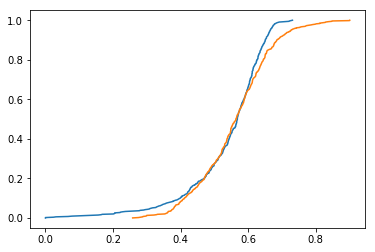

In [205]:
sort_y = np.sort(planets_etamb)
p = np.linspace(0, 1, len(planets_etamb))
data_CDF = lambda x: np.interp(x, sort_y, p)

#plotting CDF of data vs CDF of sample dataset
plt.figure(1)
plt.plot(sort_y, p)
plt.plot(np.sort(sample), p)
plt.show()

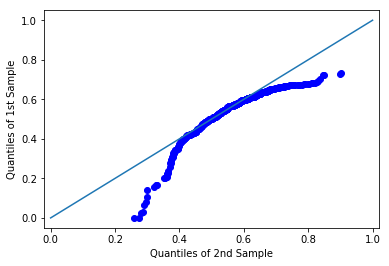

In [206]:
#qq plot for real data and "optimal param" data
plt.figure(1)
qqplot_2samples(planets_etamb, sample)
plt.plot(np.linspace(0.0,1.0),np.linspace(0.0,1.0))
plt.show()

In [207]:
def calc1000tests(m, b, yerr_mu, yerr_sig, bias_mu, bias_sig, rel):
    ks_stats = [] #each has 1000 p-values, corresponding to one set of params
    mwu_stats = []
    wilcoxon_stats = []
    for i in range(1000):
        trial = draw_samp(days, m, b, yerr_mu, yerr_sig, bias_mu, bias_sig, rel)
        stat = ks_2samp(planets_etamb, trial)
        ks_stats.append(stat[1])
        stat = mannwhitneyu(planets_etamb, trial, alternative = 'two-sided')
        mwu_stats.append(stat[1])
        stat = wilcoxon(planets_etamb, trial)
        wilcoxon_stats.append(stat[1])
        
    return ks_stats, mwu_stats, wilcoxon_stats

In [208]:
test_m = 0.0
test_b = .61
# test_yerr_mu = 0.0
# test_yerr_sig = .005
# test_bias_mu = 0.0
test_bias_sig = .08125
test_rel = 1.0
pvals_ks, pvals_mwu, pvals_w = calc1000tests(test_m, test_b, 0.0, 0.1, 0.0, test_bias_sig, test_rel)
print(pvals_w)

[0.6857129417892095, 0.46315238625849331, 0.23871750898157529, 0.71963800666716882, 0.31547067928934058, 0.77985767895373281, 0.79075627159609674, 0.17245540584196106, 0.82077697355767687, 0.58421358052315664, 0.38616246926132169, 0.38032564205848574, 0.88917275023285292, 0.21986856785882092, 0.40747247056323599, 0.44429553883420114, 0.11796959659707505, 0.69695510104117697, 0.94562288517881754, 0.38777713512709577, 0.46625616878129617, 0.36201491957585863, 0.5609194436508973, 0.64548342017246396, 0.54783894774679442, 0.13272560855785004, 0.64298968533317646, 0.19262982990566913, 0.36753454884274228, 0.7747316690593149, 0.39146210261730796, 0.65453236468407217, 0.16484383412136638, 0.53773134145230328, 0.99765250515942816, 0.64203162458991914, 0.3248445279887715, 0.46071018883922199, 0.83014961924700215, 0.43103191470449298, 0.36540543954992999, 0.46494790752659076, 0.84247470447182737, 0.51382691614621856, 0.59361864371282569, 0.90801207560622266, 0.8668171682136192, 0.684140578267834

In [168]:
# plt.figure(figsize=(12, 7))
# plt.plot(days, planets_etamb, 'bx')
# plt.plot(days, trial, 'rx')
# plt.xlabel('days')
# plt.ylabel('sampled values')
# plt.show()

In [209]:
#set range of params to test
num_trials = 5
m = np.linspace(-.001, .001, num=num_trials)
b = np.linspace(.5, .65, num=num_trials)
yerr_sig = np.linspace(0.0, .1, num=num_trials)
bias_sig = np.linspace(0.0, .1, num=num_trials)
rel = np.linspace(0.0, 3.0, num=num_trials)

In [214]:
#generate all test statistics, version without yerr and rel
a, B, c, d = np.meshgrid(m, b, bias_sig, rel)
arr = np.stack((np.ravel(a), np.ravel(B), np.ravel(c), np.ravel(d)), axis=-1)

full_results = {}
for i in arr:
    print(i)
    pvals_ks, pvals_mwu, pvals_w = calc1000tests(i[0], i[1], 0.0, yerr, 0.0, i[2], i[3]) #each an array of 1000 pvals
    full_results[str(i)] = [pvals_ks, pvals_mwu, pvals_w]

[-0.001  0.5    0.     0.   ]
[-0.001  0.5    0.     0.75 ]
[ -1.00000000e-03   5.00000000e-01   0.00000000e+00   1.50000000e+00]
[ -1.00000000e-03   5.00000000e-01   0.00000000e+00   2.25000000e+00]
[ -1.00000000e-03   5.00000000e-01   0.00000000e+00   3.00000000e+00]
[-0.001  0.5    0.025  0.   ]
[-0.001  0.5    0.025  0.75 ]
[ -1.00000000e-03   5.00000000e-01   2.50000000e-02   1.50000000e+00]
[ -1.00000000e-03   5.00000000e-01   2.50000000e-02   2.25000000e+00]
[ -1.00000000e-03   5.00000000e-01   2.50000000e-02   3.00000000e+00]
[-0.001  0.5    0.05   0.   ]
[-0.001  0.5    0.05   0.75 ]
[ -1.00000000e-03   5.00000000e-01   5.00000000e-02   1.50000000e+00]
[ -1.00000000e-03   5.00000000e-01   5.00000000e-02   2.25000000e+00]
[ -1.00000000e-03   5.00000000e-01   5.00000000e-02   3.00000000e+00]
[-0.001  0.5    0.075  0.   ]
[-0.001  0.5    0.075  0.75 ]
[ -1.00000000e-03   5.00000000e-01   7.50000000e-02   1.50000000e+00]
[ -1.00000000e-03   5.00000000e-01   7.50000000e-02   2.2500

[ -5.00000000e-04   5.37500000e-01   2.50000000e-02   0.00000000e+00]
[ -5.00000000e-04   5.37500000e-01   2.50000000e-02   7.50000000e-01]
[ -5.00000000e-04   5.37500000e-01   2.50000000e-02   1.50000000e+00]
[ -5.00000000e-04   5.37500000e-01   2.50000000e-02   2.25000000e+00]
[ -5.00000000e-04   5.37500000e-01   2.50000000e-02   3.00000000e+00]
[ -5.00000000e-04   5.37500000e-01   5.00000000e-02   0.00000000e+00]
[ -5.00000000e-04   5.37500000e-01   5.00000000e-02   7.50000000e-01]
[ -5.00000000e-04   5.37500000e-01   5.00000000e-02   1.50000000e+00]
[ -5.00000000e-04   5.37500000e-01   5.00000000e-02   2.25000000e+00]
[ -5.00000000e-04   5.37500000e-01   5.00000000e-02   3.00000000e+00]
[ -5.00000000e-04   5.37500000e-01   7.50000000e-02   0.00000000e+00]
[ -5.00000000e-04   5.37500000e-01   7.50000000e-02   7.50000000e-01]
[ -5.00000000e-04   5.37500000e-01   7.50000000e-02   1.50000000e+00]
[ -5.00000000e-04   5.37500000e-01   7.50000000e-02   2.25000000e+00]
[ -5.00000000e-04   

[ -5.00000000e-04   5.75000000e-01   1.00000000e-01   7.50000000e-01]
[ -5.00000000e-04   5.75000000e-01   1.00000000e-01   1.50000000e+00]
[ -5.00000000e-04   5.75000000e-01   1.00000000e-01   2.25000000e+00]
[ -5.00000000e-04   5.75000000e-01   1.00000000e-01   3.00000000e+00]
[ 0.     0.575  0.     0.   ]
[ 0.     0.575  0.     0.75 ]
[ 0.     0.575  0.     1.5  ]
[ 0.     0.575  0.     2.25 ]
[ 0.     0.575  0.     3.   ]
[ 0.     0.575  0.025  0.   ]
[ 0.     0.575  0.025  0.75 ]
[ 0.     0.575  0.025  1.5  ]
[ 0.     0.575  0.025  2.25 ]
[ 0.     0.575  0.025  3.   ]
[ 0.     0.575  0.05   0.   ]
[ 0.     0.575  0.05   0.75 ]
[ 0.     0.575  0.05   1.5  ]
[ 0.     0.575  0.05   2.25 ]
[ 0.     0.575  0.05   3.   ]
[ 0.     0.575  0.075  0.   ]
[ 0.     0.575  0.075  0.75 ]
[ 0.     0.575  0.075  1.5  ]
[ 0.     0.575  0.075  2.25 ]
[ 0.     0.575  0.075  3.   ]
[ 0.     0.575  0.1    0.   ]
[ 0.     0.575  0.1    0.75 ]
[ 0.     0.575  0.1    1.5  ]
[ 0.     0.575  0.1    2.25 ]


[  5.00000000e-04   6.12500000e-01   0.00000000e+00   1.50000000e+00]
[  5.00000000e-04   6.12500000e-01   0.00000000e+00   2.25000000e+00]
[  5.00000000e-04   6.12500000e-01   0.00000000e+00   3.00000000e+00]
[  5.00000000e-04   6.12500000e-01   2.50000000e-02   0.00000000e+00]
[  5.00000000e-04   6.12500000e-01   2.50000000e-02   7.50000000e-01]
[  5.00000000e-04   6.12500000e-01   2.50000000e-02   1.50000000e+00]
[  5.00000000e-04   6.12500000e-01   2.50000000e-02   2.25000000e+00]
[  5.00000000e-04   6.12500000e-01   2.50000000e-02   3.00000000e+00]
[  5.00000000e-04   6.12500000e-01   5.00000000e-02   0.00000000e+00]
[  5.00000000e-04   6.12500000e-01   5.00000000e-02   7.50000000e-01]
[  5.00000000e-04   6.12500000e-01   5.00000000e-02   1.50000000e+00]
[  5.00000000e-04   6.12500000e-01   5.00000000e-02   2.25000000e+00]
[  5.00000000e-04   6.12500000e-01   5.00000000e-02   3.00000000e+00]
[  5.00000000e-04   6.12500000e-01   7.50000000e-02   0.00000000e+00]
[  5.00000000e-04   

[  5.00000000e-04   6.50000000e-01   1.00000000e-01   7.50000000e-01]
[  5.00000000e-04   6.50000000e-01   1.00000000e-01   1.50000000e+00]
[  5.00000000e-04   6.50000000e-01   1.00000000e-01   2.25000000e+00]
[  5.00000000e-04   6.50000000e-01   1.00000000e-01   3.00000000e+00]
[ 0.001  0.65   0.     0.   ]
[ 0.001  0.65   0.     0.75 ]
[  1.00000000e-03   6.50000000e-01   0.00000000e+00   1.50000000e+00]
[  1.00000000e-03   6.50000000e-01   0.00000000e+00   2.25000000e+00]
[  1.00000000e-03   6.50000000e-01   0.00000000e+00   3.00000000e+00]
[ 0.001  0.65   0.025  0.   ]
[ 0.001  0.65   0.025  0.75 ]
[  1.00000000e-03   6.50000000e-01   2.50000000e-02   1.50000000e+00]
[  1.00000000e-03   6.50000000e-01   2.50000000e-02   2.25000000e+00]
[  1.00000000e-03   6.50000000e-01   2.50000000e-02   3.00000000e+00]
[ 0.001  0.65   0.05   0.   ]
[ 0.001  0.65   0.05   0.75 ]
[  1.00000000e-03   6.50000000e-01   5.00000000e-02   1.50000000e+00]
[  1.00000000e-03   6.50000000e-01   5.00000000e-0

In [210]:
#generate all test statistics, version with yerr
e, f, g, h = np.meshgrid(m, b, yerr_sig, bias_sig)
arr2 = np.stack((np.ravel(d), np.ravel(e), np.ravel(f), np.ravel(g)), axis=-1)

full_results_yerr = {}
for i in arr2:
    pvals_ks, pvals_mwu, pvals_w = calc1000tests(i[0], i[1], 0.0, i[2], 0.0, i[3]) #each an array of 1000 pvals
    full_results_yerr[str(i)] = [pvals_ks, pvals_mwu, pvals_w]

TypeError: calc1000tests() missing 1 required positional argument: 'rel'

In [215]:
#print all test means
for tests in full_results.values():
    print("ks mean: ", np.mean(tests[0]))
    print("mwu mean: ", np.mean(tests[1]))
    print("wilcoxon mean: ", np.mean(tests[2]))

ks mean:  7.03262928835e-180
mwu mean:  3.22579191085e-167
wilcoxon mean:  9.18712651332e-91
ks mean:  4.96973407265e-180
mwu mean:  1.53331662966e-166
wilcoxon mean:  9.22365544684e-91
ks mean:  4.16646241399e-181
mwu mean:  6.47657435164e-167
wilcoxon mean:  9.16548296575e-91
ks mean:  4.53722910495e-181
mwu mean:  5.00076740493e-167
wilcoxon mean:  9.30145203151e-91
ks mean:  1.90513504348e-179
mwu mean:  3.17692129026e-165
wilcoxon mean:  9.26655285731e-91
ks mean:  2.084145727e-179
mwu mean:  6.63197690327e-166
wilcoxon mean:  9.36798788928e-91
ks mean:  1.91047236675e-182
mwu mean:  1.08077688177e-168
wilcoxon mean:  6.37057203755e-91
ks mean:  2.31641863872e-185
mwu mean:  7.03716960328e-170
wilcoxon mean:  4.67965635605e-91
ks mean:  9.67906985844e-188
mwu mean:  7.4033129885e-171
wilcoxon mean:  3.58369158629e-91
ks mean:  2.8247979661e-189
mwu mean:  9.13319554916e-172
wilcoxon mean:  2.80098040124e-91
ks mean:  8.9055969233e-182
mwu mean:  1.7957816621e-166
wilcoxon mean:  9

ks mean:  4.49854468055e-152
mwu mean:  5.43105433812e-117
wilcoxon mean:  7.62196346704e-86
ks mean:  2.0947429081e-170
mwu mean:  7.39784266943e-140
wilcoxon mean:  1.00837836252e-89
ks mean:  2.22899252219e-160
mwu mean:  1.09546072109e-129
wilcoxon mean:  3.77973863915e-88
ks mean:  3.08831937644e-153
mwu mean:  1.2907601958e-117
wilcoxon mean:  6.88897339925e-86
ks mean:  1.95065374203e-145
mwu mean:  1.59542725475e-107
wilcoxon mean:  7.96300021926e-83
ks mean:  9.90854094485e-138
mwu mean:  1.1684268754e-93
wilcoxon mean:  7.05539295404e-79
ks mean:  1.1007431159e-169
mwu mean:  1.37987855917e-138
wilcoxon mean:  1.00110570643e-89
ks mean:  8.48022140445e-157
mwu mean:  1.30874380639e-123
wilcoxon mean:  3.71729828676e-87
ks mean:  1.09196630155e-142
mwu mean:  1.18784952335e-105
wilcoxon mean:  6.13633204003e-83
ks mean:  2.16360914205e-133
mwu mean:  6.27539967959e-90
wilcoxon mean:  8.2606760739e-77
ks mean:  1.21932595404e-122
mwu mean:  1.91083824032e-75
wilcoxon mean:  7.2

mwu mean:  3.35657265066e-133
wilcoxon mean:  1.67517323601e-85
ks mean:  7.71025521658e-137
mwu mean:  1.19069043822e-135
wilcoxon mean:  3.05730904105e-86
ks mean:  2.93127075044e-121
mwu mean:  3.66094950563e-118
wilcoxon mean:  9.15598718868e-83
ks mean:  4.05623140667e-129
mwu mean:  3.42531431907e-129
wilcoxon mean:  9.28540792352e-85
ks mean:  1.91400313448e-136
mwu mean:  2.66218530059e-137
wilcoxon mean:  2.91839757761e-86
ks mean:  2.21360351263e-144
mwu mean:  2.79559834305e-142
wilcoxon mean:  2.10163085895e-87
ks mean:  6.19693821635e-150
mwu mean:  2.09922487136e-145
wilcoxon mean:  2.72951698899e-88
ks mean:  1.10147367689e-120
mwu mean:  1.11731060813e-119
wilcoxon mean:  8.73988127972e-83
ks mean:  7.97162227948e-131
mwu mean:  2.7224296231e-134
wilcoxon mean:  1.3497355538e-85
ks mean:  8.78764734186e-144
mwu mean:  3.1789449358e-142
wilcoxon mean:  2.04386421237e-87
ks mean:  1.15078047008e-152
mwu mean:  5.54282900138e-148
wilcoxon mean:  1.19490065207e-88
ks mean: 

wilcoxon mean:  1.2828617373e-87
ks mean:  9.47717816638e-153
mwu mean:  8.82713669603e-141
wilcoxon mean:  1.33697302955e-87
ks mean:  1.0156912199e-152
mwu mean:  1.57419407576e-139
wilcoxon mean:  1.37124815219e-87
ks mean:  2.15935489869e-151
mwu mean:  2.23383115803e-139
wilcoxon mean:  1.40420922782e-87
ks mean:  3.0398719182e-154
mwu mean:  3.07408270447e-140
wilcoxon mean:  1.32472367305e-87
ks mean:  4.75215553409e-156
mwu mean:  5.68508204623e-143
wilcoxon mean:  4.70032309581e-88
ks mean:  1.2340757471e-157
mwu mean:  5.90231150267e-146
wilcoxon mean:  1.83627141322e-88
ks mean:  3.85922193164e-162
mwu mean:  2.00263810731e-148
wilcoxon mean:  8.21344761532e-89
ks mean:  1.16322717488e-163
mwu mean:  2.07725959591e-150
wilcoxon mean:  3.75624313992e-89
ks mean:  1.02491703333e-153
mwu mean:  5.58677569168e-139
wilcoxon mean:  1.3988052354e-87
ks mean:  2.69594840721e-158
mwu mean:  1.53249085611e-145
wilcoxon mean:  1.88282055062e-88
ks mean:  3.2243846321e-163
mwu mean:  3.

In [216]:
#find greatest mean for each test
greatest_ks = -np.inf
greatest_mwu = -np.inf
greatest_w = -np.inf
for params, arr in full_results.items():
    if np.mean(arr[0]) > greatest_ks:
        greatest_ks = np.mean(arr[0])
        greatest_params_ks = params
        p_vals_ks = arr[0]
    if np.mean(arr[1]) > greatest_mwu:
        greatest_mwu = np.mean(arr[1])
        greatest_params_mwu = params
        p_vals_mwu = arr[1]
    if np.mean(arr[2]) > greatest_w:
        greatest_w = np.mean(arr[2])
        greatest_params_w = params
        p_vals_w = arr[2]
print(greatest_ks, greatest_params_ks)
print(greatest_mwu, greatest_params_mwu)
print(greatest_w, greatest_params_w)

0.00552265426319 [ 0.     0.575  0.05   0.75 ]
0.559007184796 [ 0.      0.6125  0.05    1.5   ]
0.599230521536 [ 0.     0.575  0.05   0.75 ]


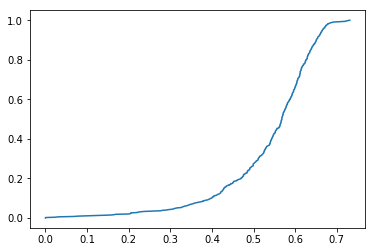

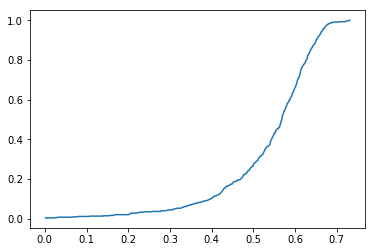

In [194]:
#two methods of plotting CDF (true dataset)
sort_y = np.sort(planets_etamb)
p = np.linspace(0, 1, len(planets_etamb))
data_CDF = lambda x: np.interp(x, sort_y, p)

plt.figure(1)
plt.plot(sort_y, p)
plt.show()

plt.figure(2)
num_bins = len(planets_etamb)
counts, bin_edges = np.histogram (planets_etamb, bins=num_bins, normed=True)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])
plt.show()

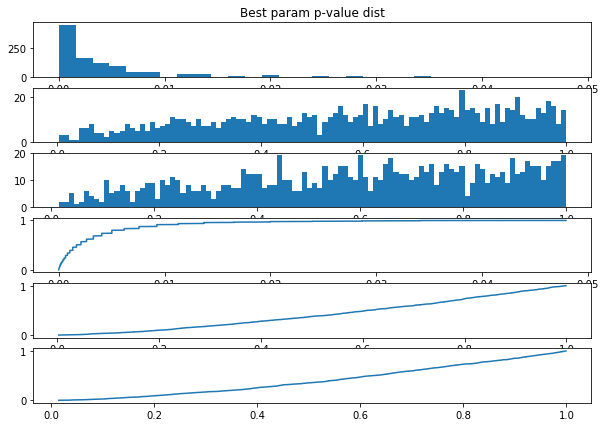

In [202]:
#plotting p value distribution and CDF of the p values
f, axarr = plt.subplots(6, figsize=(10, 7))
axarr[0].hist(p_vals_ks, bins=30)
axarr[0].set_title('Best param p-value dist')
axarr[1].hist(p_vals_mwu, bins=100)
axarr[2].hist(p_vals_w, bins=100)
ks = np.sort(p_vals_ks)
mwu = np.sort(p_vals_mwu)
w = np.sort(p_vals_w)
prob = np.linspace(0, 1, len(p_vals_w))
axarr[3].plot(ks, prob)
axarr[4].plot(mwu, prob)
axarr[5].plot(w, prob)
plt.show()

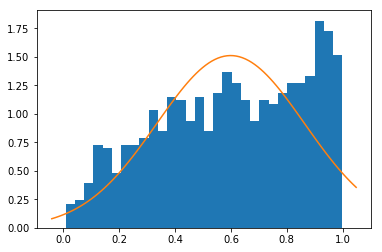

In [220]:
mu, std = norm.fit(p_vals_w)
plt.hist(p_vals_w, bins=30, normed=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mu, std)
plt.plot(x, y)
plt.show()

In [86]:
#to save results dictionary REMEMBER TO RENAME
pickle.dump(results, open(".p", "wb"))
#to read back in
#arr = pickle.load( open( "kstest_5param_5.p", "rb" ) )